In [1]:
%conda install -c conda-forge ipywidgets
# %jupyter nbextension enable --py widgetsnbextension

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.4
  latest version: 22.9.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


# What is Transfer Learning?

With more powerful infrastructure for holding that data and training the models (mainly thanks to the cloud), we have become increasingly good at training deep neural networks to learn a very accurate mapping from inputs to outputs.

In recent years, models have become increasingly larger (billions of parameters) and more and more labeled data has become available.In recent years, models have become increasingly larger (billions of parameters) and more and more labeled data has become available.

However, those models are usually trained on a specific dataset and for a specific task. In real world, you deal with messy data and new scenarios, many of which your model has not encountered during training and for which it is in turn ill-prepared to make predictions.

The ability to transfer knowledge to new conditions is generally known as **transfer learning**.

----

Figure 1 shows a classic supervised learning scenario. You train a model for some task and domain A, assuming that labeled data for the same task and domain is provided.  On another occasion, when given data for some other task or domain B, we require again labeled data of the same task or domain that we can use to train a new model B so that we can expect it to perform well on this data.

<img src="./img/lab_12_ml.png">

Figure 1: [The traditional supervised learning setup in ML](https://ruder.io/transfer-learning/)

In the other hand, Transfer learning allows us to deal with these scenarios by leveraging the already existing labeled data of some related task or domain. We try to store this knowledge gained in solving the source task in the source domain and apply it to our problem of interest as can be seen in Figure 2.


<img src="./img/lab_12_tf.png">


Figure 2: [Transfer learning setup](https://ruder.io/transfer-learning/)

------

### Steps of Transfer Learning

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.

For instance, features from a model that has learned to identify racoons may be useful to kick-start a model meant to identify possoms.

A common transfer learning workflow consists of:

* Take layers from a previously trained model.
* Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
* Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
* Train the new layers on your dataset.

A last, optional step, is fine-tuning, which consists of unfreezing the entire model you obtained above (or part of it), and re-training it on the new data with a very low learning rate. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data.

## Benchmarks for Computer Vision


* **Image classification** attempts to identify the most significant object class in the image. [List of models for image classification on ImageNet data](https://paperswithcode.com/sota/image-classification-on-imagenet)
* **Object Detection** models return a set of coordinates, called a bounding box, that specify an area of the input image containing an object, along with confidence value for that bounding box and a label. [List of models for object detection](https://paperswithcode.com/task/object-detection)
* **Image Segmentation** models generate a pixel level boundary for each object. Image segmentation models classify each pixel in an image by either object type, in the case of semantic segmentation, or by individual objects, in the case of instance segmentation. [list](https://paperswithcode.com/task/semantic-segmentation)

----

In [2]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2022-11-30 16:50:15.131810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
height = 224
width = 224
channels = 3
batch_size = 64
img_shape = (height, width, channels)
img_size = (height, width)

data_dir = "./data/archive/images/"

In [4]:
data = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

Found 101000 files belonging to 101 classes.


2022-11-30 16:51:17.089082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Creating an ImageDataGenerator and doing Image Augmentation
datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split = 0.2)

In [6]:
train_data = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')

val_data = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation')

Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


In [7]:
NUM_CLASSES = len(train_data.class_indices)

Now let's check papers with code to see the best performing model for Food-101:

https://paperswithcode.com/sota/fine-grained-image-classification-on-food-101

Efficient Net B0: This model takes input images of shape (224, 224, 3)and the input data should range [0, 255]. Normalization is included as part of the model.


Replacing the top layer with custom layers allows using EfficientNet as a feature extractor in a transfer learning workflow.

In [8]:
from tensorflow.keras.applications import EfficientNetB0

In [9]:
def build_model(num_classes, input_shape=img_shape):
    inputs = layers.Input(shape=input_shape)
    
    x = inputs
    model = EfficientNetB0(include_top=False, 
                           input_tensor=x, 
                           weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [10]:
model = build_model(num_classes=NUM_CLASSES)

In [11]:
# model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]'

In [12]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
epochs = 1
hist = model.fit(train_data,
                 epochs=epochs, 
                 validation_data=val_data,
                 verbose=1
                )

1263/1263 [==============================] - 10791s 9s/step - loss: 4.8025 - accuracy: 0.0101 - val_loss: 4.6426 - val_accuracy: 0.0099


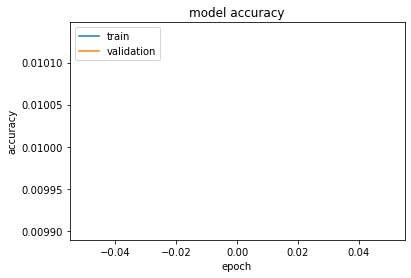

In [14]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

### Fine-tuning (optional)

The second step is to unfreeze a number of layers and fit the model using smaller learning rate. In this example we show unfreezing 5 layers, but depending on specific dataset it may be desireble to  unfreeze all or a fraction of layers.

On the other hand, when we use pretrained weights on a dataset that is more different from ImageNet, this fine-tuning step can be crucial as the feature extractor also needs to be adjusted by a considerable amount. In such a case the convergence may take more than 50 epochs.

In [15]:
def unfreeze_model(model, num_layers=5):
    # We unfreeze the top 5 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-num_layers:]:
        if not isinstance(layer, layers.BatchNormalization):
            print(layer)
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [17]:
unfreeze_model(model)

In [18]:
# Create checkpoint callback to save model for later use
checkpoint_path = "./data/checkpoints/"
!mkdir -p $checkpoint_path

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy",
                                                         save_best_only=True
                                                        )

In [ ]:
hist_ft = model.fit(train_data,
                 epochs=epochs, 
                 validation_data=val_data,
                 verbose=1,
                 callbacks=[checkpoint_callback]
                )

plot_hist(hist_ft)

 377/1263 [=======>......................] - ETA: 2:08:28 - loss: 4.6414 - accuracy: 0.0102